In [4]:
if __name__ == '__main__':
    from collections import Counter

    def snr(origianl_waveform, target_waveform):
        signal = np.sum(origianl_waveform ** 2)
        noise = np.sum((origianl_waveform - target_waveform) ** 2)
        snr = 10 * np.log10(signal / noise)
        return snr

    def to_TMHINT_name(sample):
        return f'TMHINT_{(sample-1)//10+1:02d}_{(sample-1)%10+1:02d}'


    noise_type = args.train_noise_type[50]
    noisy_snr = []
    for sample in range(1, 251):
        _, noisy_data = wavfile.read(f'../../Dataset/Training/Noisy/{noise_type}/{sample}.wav')
        _, clean_data = wavfile.read(f'../../Dataset/Training/Clean/{sample}.wav')
        noisy_data = noisy_data.astype('float')
        clean_data = clean_data.astype('float')
        noisy_snr.append(int(round(snr(clean_data, noisy_data))))
#     print(SNR_type, ':', noisy_snr)
    counter = Counter(noisy_snr)
    print(sorted(counter.items()))
#     for k, v in sorted(counter.items()):
#         print(k, v)


#     noise_type = args.test_noise_type[1]
#     for SNR_type in args.test_SNR_type:
#         noisy_snr = []
#         for sample in range(1, 71):
#             _, noisy_data = wavfile.read(f'../../Dataset/Testing/Noisy/{noise_type}/a1/{SNR_type}/{to_TMHINT_name(sample)}.wav')
#             _, clean_data = wavfile.read(f'../../Dataset/Testing/Clean/a1/{to_TMHINT_name(sample)}.wav')
#             noisy_data = noisy_data.astype('float')
#             clean_data = clean_data.astype('float')
#             noisy_snr.append(int(round(snr(clean_data, noisy_data))))
#         print(SNR_type, ':', noisy_snr)

[(-10, 8), (-9, 8), (-8, 8), (-7, 8), (-6, 8), (-5, 8), (-4, 8), (-3, 8), (-2, 8), (-1, 8), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (10, 8), (11, 8), (12, 8), (13, 8), (14, 8), (15, 8), (16, 8), (17, 8), (18, 8), (19, 9), (20, 9)]


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.onnx

import os
import cv2
import copy
import netron
import timeit
import random
import librosa
import scipy
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False, fscale=2, figsize=(8, 6))

from IPython.display import Audio, display
from tqdm.notebook import tqdm
from scipy.io import wavfile
from pesq import pesq
from pystoi import stoi
from matplotlib import cm
from argparse import Namespace
from collections import OrderedDict

import import_ipynb
import NewAutoEncoder
from NewAutoEncoder import AutoEncoder


args = Namespace(
    split_ratio=0.2,
    epoch=40,
    batch_size=1,
    kernel=3,
    lr=0.0001,
    loss_coef=0.001,
    shift=12,
    AE_checkpoint_path=f'checkpoint/AutuEncoder/',
    SCNN_checkpoint_path=f'checkpoint/MultiModal/',
    
    EPSILON=1e-12,
    n_fft=512,
    hop_length=160,
    win_length=512,
    window=scipy.signal.hamming,
)
args.FBIN = args.n_fft // 2 + 1
args.device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

args.train_noise_type = [
    'cafeteria_babble',
    'crowd-party-adult-med',
    *[f'n{i}' for i in range(1, 101)],
    'street noise',
    'street noise_downtown',
]

args.test_noise_type = [
    'car_noise_idle_noise_60_mph',
    'engine',
    'pinknoise_16k',
    'street',
    'street noise',
    'taiwan_3talker',
    'white',
]

args.test_SNR_type = [
    'n10dB', 'n7dB', 'n6dB', 'n5dB', 'n3dB', 'n1dB', '0dB',
    '1dB', '3dB', '4dB', '5dB', '6dB', '9dB', '10dB', '15dB',
]


importing Jupyter notebook from NewAutoEncoder.ipynb


In [2]:
def wav2spec(filename, norm=False):
    sr, wave_data = wavfile.read(filename)
    wave_data = wave_data.astype('float')
    wave_data = wave_data / np.max(abs(wave_data))
    
    # numpy: (257, frames)
    D = librosa.stft(wave_data,
                     n_fft=args.n_fft,
                     hop_length=args.hop_length,
                     win_length=args.win_length,
                     window=args.window)

#     S = np.log10(abs(D) + 1)
    try:
        S = 2 * np.log10(abs(D))
    except:
        print('D == 0')
        S = 2 * np.log10(abs(D) + args.EPSILON)
    
    phase = np.exp(1j * np.angle(D))
    
    if norm:
        mean = np.mean(S, axis=-1, keepdims=True)
        std = np.std(S, axis=-1, keepdims=True) + args.EPSILON
        S = (S - mean) / std
    else:
        mean = 0
        std = 1
    
    return S, phase, mean, std

def spec2wav(S, phase, mean=0, std=1):
#     D = np.multiply(10**(S * std + mean) - 1, phase)
    D = np.multiply(10**((S * std + mean) / 2), phase)
    return librosa.istft(D,
                         hop_length=args.hop_length,
                         win_length=args.win_length,
                         window=args.window)

def to_TMHINT_name(sample):
    return f'TMHINT_{(sample-1)//10+1:02d}_{(sample-1)%10+1:02d}'

def cache_clean_data(elec_preprocessor=None, is_training=True, force_update=False, device=None):
    '''
    Args:
        elec_preprocessor: int, (int, int), nn.Module or None
            Example:
                elec_preprocessor = 45        # from 1 to 45 
                elec_preprocessor = (1, 124)  # from 1 to 124
                elec_preprocessor = Encoder() # input 124
                elec_preprocessor = None      # do not load elec data
        
        is_training (bool, optional): is training or not. Default: ``True``
        force_update (bool, optional): force reload data. Default: ``False``
        device (str, optional): load data into cuda or cpu.  Default: ``None``

    Output: dataset
        - **dataset['spec']** of shape `(1, 1, wave signal length)`: tensor if is_training is ``True``
          `(wave signal length)`: numpy else

        - **dataset['elec']** of shape `(1, [electrodes/hidden], wave signal length)`: tensor if elec_preprocessor is not ``None``.
    '''
    global dataset
    
    if isinstance(elec_preprocessor, nn.Module):
        auto_encoder = elec_preprocessor
        elec_channel = (1, 124)
        hidden_size = list(model.Encoder.state_dict().values())[-1].shape[0]

    elif isinstance(elec_preprocessor, int):
        elec_channel = (1, elec_preprocessor)
        hidden_size = elec_channel[1] - elec_channel[0] + 1

    elif isinstance(elec_preprocessor, tuple) and len(elec_preprocessor) == 2:
        elec_channel = elec_preprocessor
        hidden_size = elec_channel[1] - elec_channel[0] + 1

    elif elec_preprocessor is not None:
        raise TypeError('Unknown type: elec_preprocessor')

    if not force_update and 'dataset' in globals() and ( \
        (elec_preprocessor is None) or \
        ('elec' in dataset and hidden_size == dataset['elec'][1].size(2))):
        return dataset
    
    # ===== Initialize dataset =====
    dataset = { 'spec': [0] }
    if elec_preprocessor is not None:
        dataset['elec'] = [0]

    # ===== Select [Train/Test] directory =====
    if is_training:
        data_range = range(1, 251)
        data_dir = f'../../Dataset/Training/Clean/'
    else:
        data_range = range(1, 71)
        data_dir = f'../../Dataset/Testing/Clean/a1/'

    # ===== For all samples =====
    for sample in data_range:
        if sample == 103:
            # broken data
            dataset['spec'].append(0)
            if 'elec' in dataset:
                dataset['elec'].append(0)
            continue

        # ===== Load wave data and nomarlize =====
        if is_training:
            sample_name = f'{data_dir}{sample}.wav'
        else:
            sample_name = f'{data_dir}{to_TMHINT_name(sample)}.wav'

        Sy, phasey, _, _ = wav2spec(sample_name)

        if is_training:
            # tensor shape: (1, 1, wave signal length)
            dataset['spec'].append(torch.Tensor([Sy.T]).to(device))
        else:
            # numpy shape: (wave signal length)
            dataset['spec'].append(spec2wav(Sy, phasey))

        if 'elec' in dataset:
            # ===== Load electrical data =====
            if is_training:
                filename = f'../../raw data/split electro/E{sample+70:03d}.csv'
            else:
                filename = f'../../raw data/split electro/E{sample:03d}.csv'
            elec_data = np.genfromtxt(filename, delimiter=',', dtype=np.float32)

            # ===== Extract channels and time shift =====
            # final numpy shape: (electrodes, signal length)
            elec_data = elec_data[:Sy.shape[1]-args.shift, elec_channel[0]:elec_channel[1]+1]
            elec_data = np.vstack([np.zeros((args.shift, elec_data.shape[1])), elec_data])

            # ===== Use auto_encoder compress electrical data =====
            # final numpy shape: (hidden, elec signal length)
#             if auto_encoder:
#                 with torch.no_grad():
#                     # numpy shape: (electrodes, elec signal length) => tensor shape: (elec signal length, 1, hidden)
#                     elec_data = auto_encoder.encoder(torch.Tensor(elec_data.T).unsqueeze(1).to(args.device))

#                     # tensor shape: (elec signal length, 1, hidden) => numpy shape: (hidden, elec signal length)
#                     elec_data = elec_data.squeeze(dim=1).cpu().detach().numpy().T

            # ===== Resample to 16k =====
            # final numpy shape: ([electrodes/hidden], wave signal length)
#             elec_data = cv2.resize(elec_data, dsize=(wave_data.shape[0], elec_data.shape[0]),
#                                    interpolation=cv2.INTER_CUBIC)
#                                    interpolation=cv2.INTER_NEAREST)

            # final numpy shape: (1, [electrodes/hidden], wave signal length)
            dataset['elec'].append(torch.Tensor([elec_data]).to(device))

            # final numpy shape: ([electrodes/hidden], wave signal length)
#             dataset['elec'].append(elec_data)
    return dataset

def load_data(noise_type, sample, norm=False, is_training=True):
    '''
    return (noisy wave, [elec/None], clean wave) in tensor form
    '''
    if is_training:
        noisy_file = f'../../Dataset/Training/Noisy/{noise_type}/{sample}.wav'
    else:
        noisy_file = f'../../Dataset/Testing/Noisy/{noise_type}/{to_TMHINT_name(sample)}.wav'

    Sx, phasex, _, _ = wav2spec(noisy_file, norm)
    
    if 'elec' in dataset:
        return (Sx, phasex, dataset['elec'][sample], dataset['spec'][sample])
    
    return (Sx, phasex, None, dataset['spec'][sample])

In [3]:
class Reshape(nn.Module):
    def __init__(self, channel, height):
        super(Reshape, self).__init__()
        self.channel = channel
        self.height = height
        
    def forward(self, x):
        return x.permute(0, 2, 3, 1).reshape(1, -1, self.channel * self.height)


class Unsqueeze(nn.Module):
    def __init__(self, dim):
        super(Unsqueeze, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.unsqueeze(self.dim)


In [4]:
class MultiModal_SE(nn.Module):
    '''
    Args:
        S_Encoder (nn.Sequential): a model convert noisy spectrum to clean spectrum
        
        elec_channel: 2d-tuple or AutoEncoder
        is_late_fusion (bool, optional)
        use_norm (bool, optional): Whether the input spectrum is normalized. Default: ``False``
    
    Shape:
        - Input:
            s  :math:`(N, Seq_{in}, 257)`
            e  :math:`(N, Seq_{in}, 124)`
        - Output: :math:`(N, Seq_{in}, 257)`
    '''
    def __init__(self,
                 S_Encoder: nn.Sequential = None,
                 E_Encoder: nn.Sequential = None,
                 S_Decoder: nn.Sequential = None,
                 E_Decoder: nn.Sequential = None,
                 Fusion_layer: nn.Sequential = None,
                 is_late_fusion: bool = False,
                 fusion_type: str = 'concat',
                 fusion_channel: int = -1,
                 use_norm: bool = False):
        
        super(MultiModal_SE, self).__init__()
        
        self.S_Encoder = S_Encoder
        self.E_Encoder = E_Encoder
        self.S_Decoder = S_Decoder
        self.E_Decoder = E_Decoder
        self.Fusion_layer = Fusion_layer
        
        self.is_late_fusion = is_late_fusion
        self.fusion_type = fusion_type
        self.fusion_channel = fusion_channel
        
        self.use_norm = use_norm

    def forward_submodule(self, module, data):
        '''
        Assist LSTM forwarding in Sequntial.
        '''
        if module is None or data is None:
            return None

        if isinstance(module, nn.Sequential):
            for submodule in module:
                data = self.forward_submodule(submodule, data)
#                 if isinstance(submodule, nn.LSTM):
#                     submodule.flatten_parameters()
#                     data = submodule(data)[0]
#                 else:
#                     data = submodule(data)
            return data
        
        elif isinstance(module, nn.LSTM):
            module.flatten_parameters()
            return module(data)[0]
        
        return module(data)
    
    def forward(self, s, e=None):
        '''
            
            return (Hidden state of spectrum,
                    hidden state of electric signal,
                    hidden state of fusion,
                    prediction of spectrum,
                    prediction of electric)
        '''
        
        # Make sure all data exists.
        if s is None and e is not None:
            s = torch.zeros((1, e.shape[1], 257)).to(args.device)
        
        if self.E_Encoder is not None:
            if e is None and s is not None:
                e = torch.zeros((1, s.shape[1], 124)).to(args.device)
            
            h_e = self.forward_submodule(self.E_Encoder, e)
            
            if self.is_late_fusion:
                # In late fusion, we mix the information of h_s and h_e
                h_s = self.forward_submodule(self.S_Encoder, s)
            else:
                # In early fusion, we mix the information of s and h_e
                h_s = s
            
            # fution type (Default: 'concat')
            if self.fusion_type in 'concatenate':
                # concat position: 0 for channel, -1 for frequency domain (Default: -1)
                h = torch.cat((h_s, h_e), dim=self.fusion_channel)

            elif self.fusion_type in 'mean':
                h = (h_s + h_e) / 2

            elif self.fusion_type in 'mask':
                h = torch.mul(h_s, h_e)
                h_e = h

            h_f = self.forward_submodule(self.Fusion_layer, h)
            y_ = self.forward_submodule(self.S_Decoder, h_f)
            e_ = self.forward_submodule(self.E_Decoder, h_f)
            
            if self.is_late_fusion:
                return h_s, h_e, h_f, y_, e_
            return None, h_e, h_f, y_, e_

        else:
            h_s = self.forward_submodule(self.S_Encoder, s)
            y_ = self.forward_submodule(self.S_Decoder, h_s)
            e_ = self.forward_submodule(self.E_Decoder, h_s)
            return h_s, None, None, y_, e_
    
    def get_loss(self, loss_fn, pred_y, true_y, true_e=None, lamb=0.1):
        loss = loss_fn(pred_y[-2], true_y)
        if pred_y[-1] is not None and true_e is not None:
            loss += lamb * loss_fn(pred_y[-1], true_e)
        return loss
    
    def is_use_E(self):
        return self.E_Encoder is not None

    def load_model(self, checkpoint_path, filename, device=args.device):
        try:
            state_dict = torch.load(
                os.path.join(checkpoint_path, filename),
                map_location=device
            )
            
            self.S_Encoder = state_dict.get('S_Encoder', self.S_Encoder)
            self.E_Encoder = state_dict.get('E_Encoder', self.E_Encoder)
            self.S_Decoder = state_dict.get('S_Decoder', self.S_Decoder)
            self.E_Decoder = state_dict.get('E_Decoder', self.E_Decoder)
            self.Fusion_layer = state_dict.get('Fusion_layer', self.Fusion_layer)
            
            self.is_late_fusion = state_dict.get('is_late_fusion', self.is_late_fusion)
            self.fusion_type = state_dict.get('fusion_type', self.fusion_type)
            self.fusion_channel = state_dict.get('fusion_channel', self.fusion_channel)
            
            self.use_norm = state_dict.get('use_norm', self.use_norm)
            
            print(f"Model '{filename}' loaded.")
        except Exception as e:
            print(e)
        
        self.to(device)
        return self
    
    def save_model(self, checkpoint_path, filename):
        state_dict = {
            'S_Encoder': self.S_Encoder,
            'E_Encoder': self.E_Encoder,
            'S_Decoder': self.S_Decoder,
            'E_Decoder': self.E_Decoder,
            'Fusion_layer': self.Fusion_layer,
            'is_late_fusion': self.is_late_fusion,
            'fusion_type': self.fusion_type,
            'fusion_channel': self.fusion_channel,
            'use_norm': self.use_norm,
        }
    
        torch.save(state_dict, os.path.join(checkpoint_path, filename))

In [5]:
def training(model, loss_fn, optimizer, filename):
#     try:
#         model.load_model(args.SCNN_checkpoint_path, f'{filename} 25 shot (Epoch 40).pt')
#         model.to(args.device)
#     except:
#         print(f'Error! Can not load file {filename}.')
    
    try:
        os.makedirs(args.SCNN_checkpoint_path)
    except:
        pass
    
#     samples = [random.sample(list(range(1, 103)) + list(range(104, 251)), k=50) for _ in range(len(args.train_noise_type))]
    
    saved_epoch = 0
    min_valid_loss = 1e10
    loss_hist = { 'train loss': [], 'valid loss': [] }
    with tqdm(range(1, args.epoch + 1)) as pbar1, \
         tqdm(total=len(args.train_noise_type)) as pbar2, \
         tqdm(total=len(args.train_noise_type)) as pbar3:
#          tqdm(total=249, bar_format='{desc}: {percentage:.3f}%|{bar}| {n_fmt}/{total_fmt} [{postfix}]') as pbar3:
        for epoch in pbar1:
            loss_hist['train loss'] = []
            
            pbar2.reset()
#             pbar2.set_description_str(f'Epoch: {epoch}')
            for n, noise_type in enumerate(args.train_noise_type):
                bs = 0
                loss = 0
                
                pbar2.set_description_str(f'(Epoch {epoch}) noise type: {noise_type}')
#                 pbar3.reset()
#                 pbar3.set_description_str(f'noise type: {noise_type}')
#                 for sample in samples[n]:
                for sample in range(1, 224):
#                 for sample in random.sample(list(range(1, 251)), k=10):
                    if sample == 103:
#                         sample = random.sample(list(range(1, 251)), k=1)
                        continue

                    Sx, _, elec, clean = load_data(noise_type, sample, norm=model.use_norm)
                    noisy = torch.Tensor([Sx.T]).to(args.device)

                    r = random.random() * 3
                    if r <= 1:
                        elec = None
                    elif r <= 2:
                        noisy = None

                    enhan = model(noisy, elec)
                    loss += model.get_loss(loss_fn, enhan, clean, elec, args.loss_coef)
                    bs += 1
                    if bs >= args.batch_size:
                        loss /= bs
                        loss_item = loss.item()
                        
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                        loss_hist['train loss'].append(loss_item)
                        loss = 0
                        bs = 0
#                         pbar3.set_postfix(loss=loss_item)

#                     pbar3.update()
                    pbar2.refresh()
                    pbar1.refresh()

                if bs != 0:
                    loss /= bs
                    loss_item = loss.item()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    loss_hist['train loss'].append(loss_item)
                    loss = 0
                    bs = 0

                pbar2.set_postfix(loss=loss_item)
                pbar2.update()
#                 model.save_model(args.SCNN_checkpoint_path, f'{filename} (Epoch {args.epoch} test).pt')

            # ===== Validation =====
            pbar3.reset()
            valid_loss = 0
            valid_sample = 0
            for n, noise_type in enumerate(args.train_noise_type):
                pbar3.set_description_str(f'noise type: {noise_type}')
                for sample in range(224, 251):
                    Sx, _, elec, clean = load_data(noise_type, sample, norm=model.use_norm)
                    noisy = torch.Tensor([Sx.T]).to(args.device)

                    with torch.no_grad():
                        enhan = model(noisy, elec)
                        valid_loss += model.get_loss(loss_fn, enhan, clean).item()
                    valid_sample += 1
                    
                    pbar3.set_postfix(valid_loss=valid_loss/valid_sample)
                    pbar1.refresh()
                pbar3.update()

            valid_loss /= valid_sample
            loss_hist['valid loss'].append(valid_loss)

            if valid_loss < min_valid_loss:
                min_valid_loss = valid_loss
                saved_epoch = epoch
                model.save_model(args.SCNN_checkpoint_path, f'{filename} (Epoch {args.epoch}).pt')

            pbar3.set_description_str(f'Saved Epoch: {saved_epoch}, min valid loss: {min_valid_loss}')

#             plt.figure()
            plt.plot(loss_hist['train loss'])
            plt.plot(np.linspace(0, len(loss_hist['train loss']), len(loss_hist['valid loss'])), loss_hist['valid loss'])
#             plt.xlabel('iteration')
#             plt.ylabel('loss')
            plt.legend(['Train', 'Valid'])
            plt.tight_layout(pad=0.2)
#             if epoch == 1:
#                 plt.savefig(args.SCNN_checkpoint_path + f'{filename} (Epoch 1).svg')
            plt.show()

In [6]:
import itertools

CNN_param = [[[2**(3+i), 2**(4+i), 1],
              [2**(4+i), 2**(4+i), 1],
              [2**(4+i), 2**(4+i), 3]]
             for i in range(4)]

CNN_param[0][0][0] = 1

# S2S = nn.Sequential(OrderedDict(list(itertools.chain(*[
#         [
#             (f'conv_{i}_{j}', nn.Conv2d(in_channel, out_channel, kernel_size=(3, 3), stride=(1, y_stride), padding=(1, 1))),
#             (f'norm_{i}_{j}', nn.InstanceNorm2d(out_channel, affine=True)),
#             (f'relu_{i}_{j}', nn.LeakyReLU(negative_slope=0.3, inplace=True))
#         ]
#         for i, submodule in enumerate(CNN_param)
#         for j, (in_channel, out_channel, y_stride) in enumerate(submodule)
# ]))))
# print(S2S)

# modules = []
# for i, submodule_param in enumerate(CNN_param):
#     submodule = []
#     for j, (in_channel, out_channel, y_stride) in enumerate(submodule_param):
#         submodule.extend([
#             (f'conv_{i}_{j}', nn.Conv2d(in_channel, out_channel, kernel_size=(3, 3), stride=(1, y_stride), padding=(1, 1))),
#             (f'norm_{i}_{j}', nn.InstanceNorm2d(out_channel, affine=True)),
#             (f'relu_{i}_{j}', nn.LeakyReLU(negative_slope=0.3, inplace=True))
#         ])
#     modules.append((f'submodule_{i}', nn.Sequential(OrderedDict(submodule))))

# S2S_ = nn.Sequential(OrderedDict(modules))

# S2S_ = nn.Sequential(OrderedDict([('unsqueeze', Unsqueeze(0))] + list(itertools.chain(*[[
#     (f'submodule_{i}', nn.Sequential(OrderedDict(list(itertools.chain(*[[
#         (f'conv_{i}_{j}', nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=(1, y_stride), padding=1)),
#         (f'norm_{i}_{j}', nn.InstanceNorm2d(out_channel, affine=True)),
#         (f'relu_{i}_{j}', nn.LeakyReLU(negative_slope=0.3, inplace=True))]
#         for j, (in_channel, out_channel, y_stride) in enumerate(submodule_param)
#     ])))))]
#     for i, submodule_param in enumerate(CNN_param)
# ]))))

S2S_ = nn.Sequential(OrderedDict([
    ('unsqueeze', Unsqueeze(0)),
    ('conv_0', nn.Conv2d(1, 32, (5, 25), 1, (2, 12), bias=False)),
    ('norm_0', nn.InstanceNorm2d(32, affine=True)),
    ('pool_1', nn.MaxPool2d((1, 2))),
    ('conv_2', nn.Conv2d(32, 32, (5, 17), 1, (2, 8), bias=False)),
    ('norm_2', nn.InstanceNorm2d(32, affine=True)),
    ('conv_3', nn.Conv2d(32, 16, (5, 9), 1, (2, 4), bias=False)),
    ('norm_3', nn.InstanceNorm2d(16, affine=True)),
    ('reshape', Reshape(16, 128))
]))

E2S=nn.Sequential(
    nn.Linear(124, 12),
    nn.LayerNorm(12, elementwise_affine=True),
    nn.LeakyReLU(negative_slope=0.3, inplace=True),
)

Fusion_layer = nn.Sequential(OrderedDict([
    ('lstm', nn.LSTM(input_size=2060, hidden_size=512, bias=False, batch_first=True, dropout=0)),
    ('L_0', nn.Linear(512, 512, bias=False)),
    ('norm_0', nn.LayerNorm(512, elementwise_affine=True)),
    ('relu_0', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
    ('L_1', nn.Linear(512, 1 * 257, bias=False)),
    ('relu_1', nn.LeakyReLU(negative_slope=0.3, inplace=True))
]))
# print(Fusion_layer)

In [8]:
# AE_filename = 'AE124_BiLSTM12NR S.pt'
# AE = AutoEncoder().load_model(args.AE_checkpoint_path, AE_filename, device=args.device).Encoder
# print(next(AE.parameters()).device)

Model 'AE124_BiLSTM12NR S.pt' loaded.
cuda:2


Model 'S+E LAVSE_CNN2048 AE12 EF cat2 LSTM_512_Linear (norm) (Epoch 40).pt' loaded.
Caching data ...
Cached!


/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Unsqueeze. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


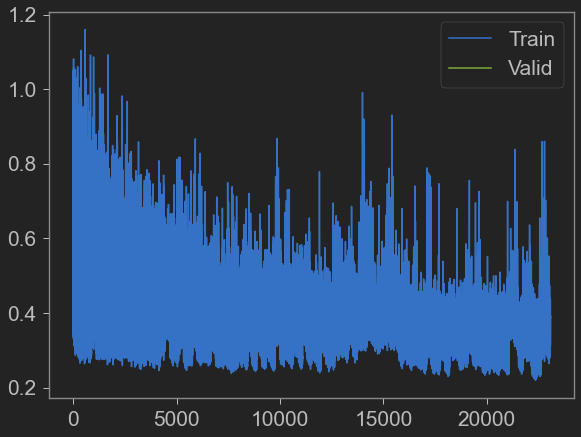

/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Unsqueeze. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


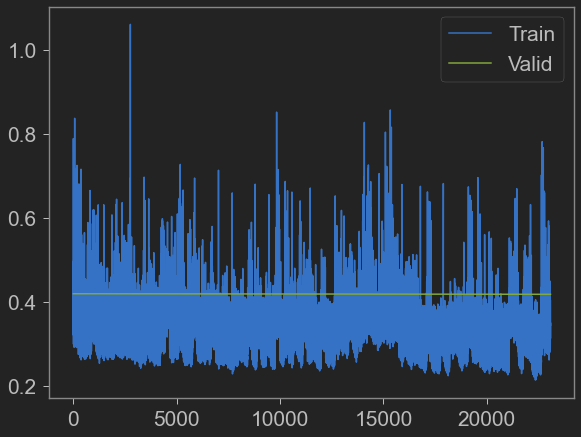

/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Unsqueeze. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


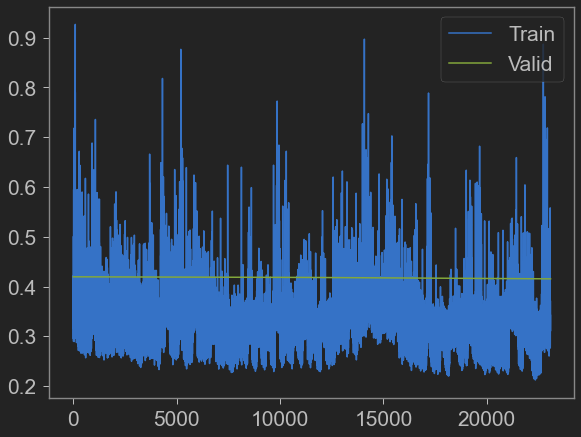

/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Unsqueeze. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


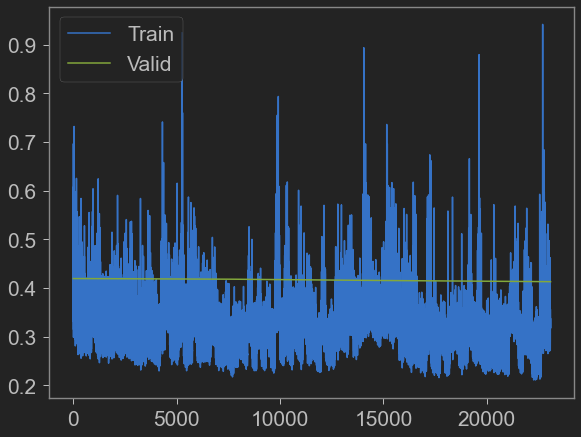

/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Unsqueeze. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/alexchen/anaconda3/envs/ASR3_7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


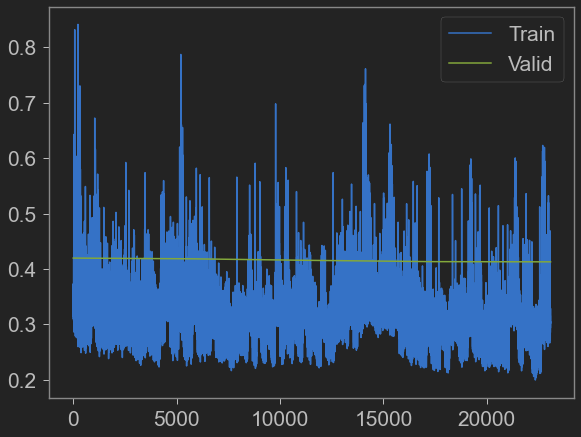

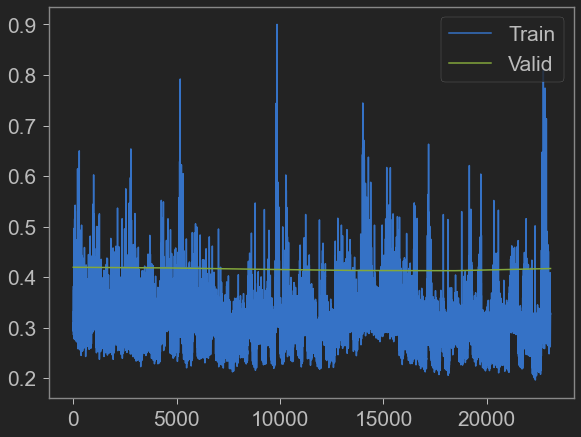

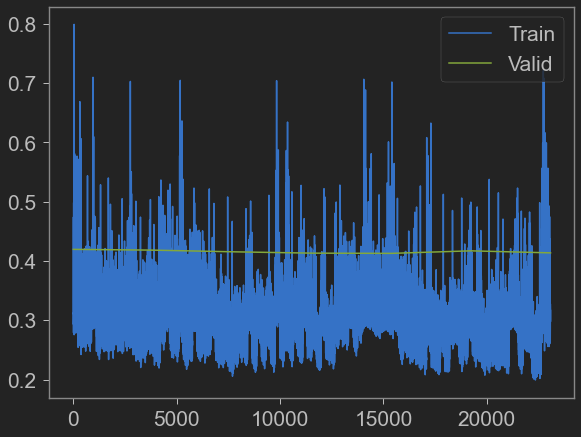

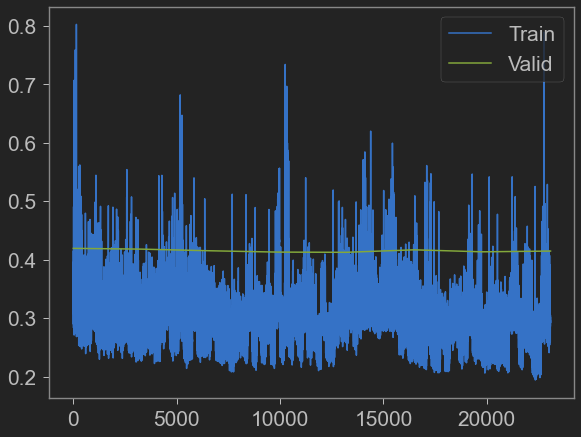

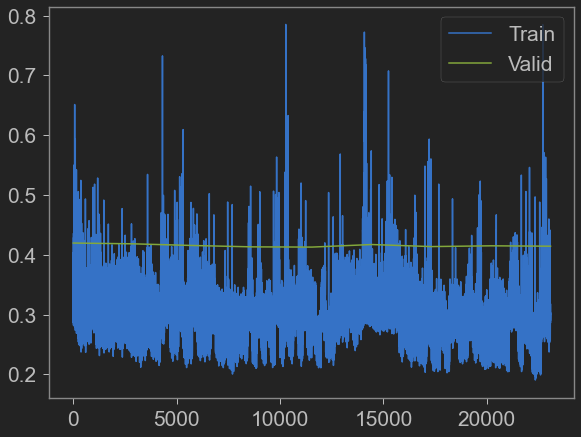

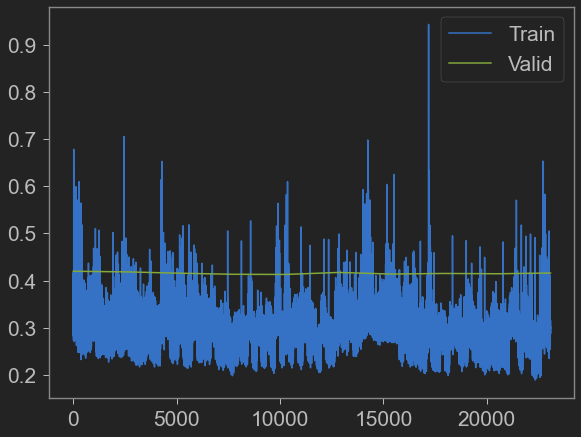

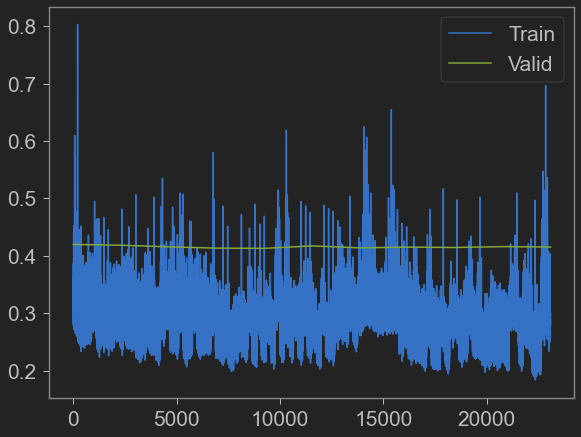

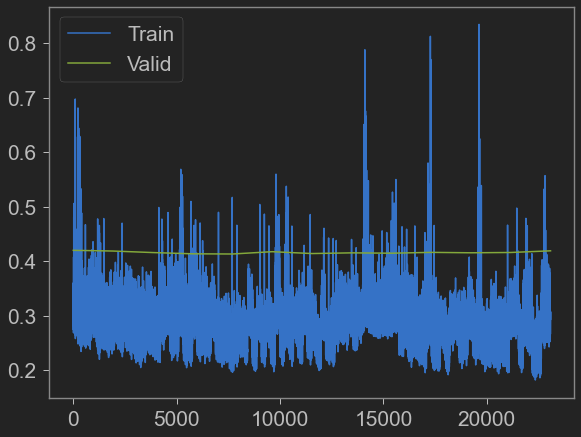

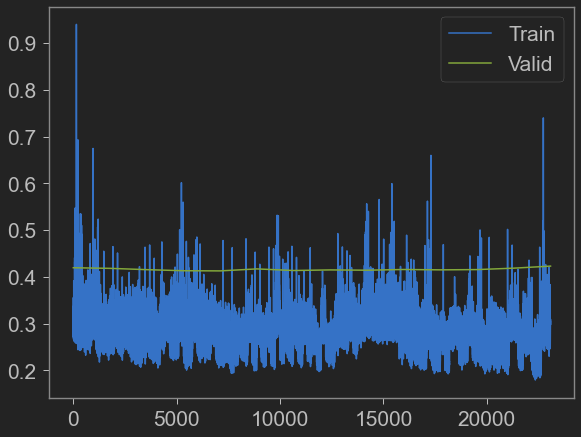

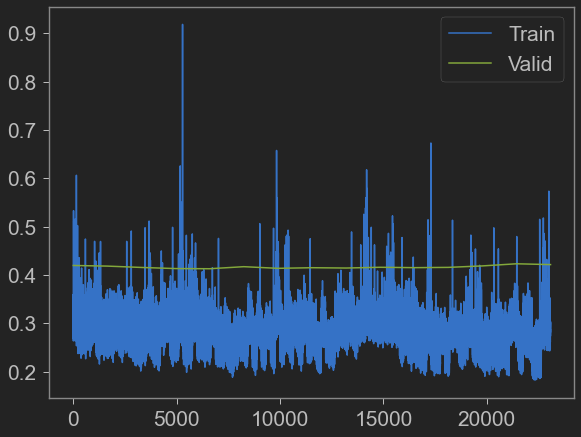

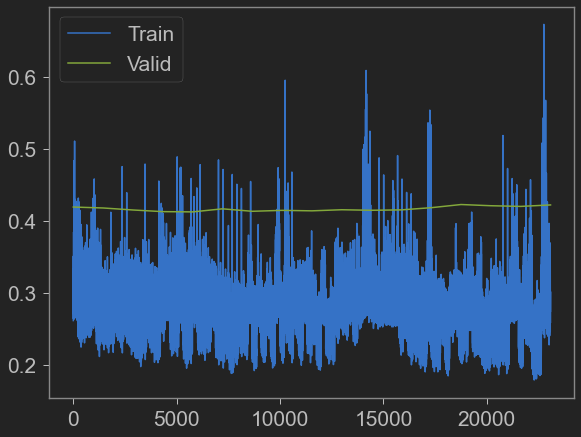

In [ ]:
if __name__ == '__main__':
    AE_filename = 'AE_124_Linear_12_tanh.pt'
    AE = AutoEncoder().load_model(args.AE_checkpoint_path, AE_filename).encoder
#     for param in AE.parameters():
#         param.requires_grad = False
#     print(f"AutoEncoder '{AE_filename}' loaded.")
    
#     filename = 'S2S+E CNN_32_16 k_5_124 stride_1_1 LF cat 2Linear (1 loss)'
    filename = 'S+E LAVSE_CNN2048 AE12 LF cat2 LSTM_512_Linear E (norm)'
#     model = MultiModal_SE(
        # (N, Seq, 257) -> (N, Seq, 16 * 128)
#         S_Encoder=nn.Sequential(OrderedDict([
#             ('unsqueeze', Unsqueeze(0)),
#             ('conv_0', nn.Conv2d(1, 32, (5, 25), 1, (2, 12), bias=False)),
#             ('norm_0', nn.InstanceNorm2d(32, affine=True)),
#             ('pool_1', nn.MaxPool2d((1, 2))),
#             ('conv_2', nn.Conv2d(32, 32, (5, 17), 1, (2, 8), bias=False)),
#             ('norm_2', nn.InstanceNorm2d(32, affine=True)),
#             ('conv_3', nn.Conv2d(32, 16, (5, 9), 1, (2, 4), bias=False)),
#             ('norm_3', nn.InstanceNorm2d(16, affine=True)),
#             ('reshape', Reshape(16, 128)),
#         ])),
        
        # (N, Seq, 124) -> (N, Seq, 12) or None
#         E_Encoder=AE,
#         E2S=nn.Sequential(
#             nn.Linear(124, 12),
#             nn.LayerNorm(12, elementwise_affine=True),
#             nn.LeakyReLU(negative_slope=0.3, inplace=True),
#         ),
        
#         # (N, Seq, input fusion shape) -> (N, Seq, output fusion shape) or None
#         Fusion_layer=nn.Sequential(OrderedDict([
#             ('linear', nn.Linear(257 + 12, 257, bias=False)),
#             ('norm', nn.LayerNorm(257, elementwise_affine=True)),
#             ('relu', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
#         ])),
        
#         # (N, Seq, output fusion shape or S_Encoder output shape) -> (N, Seq, 257)
#         S_Decoder=nn.Sequential(OrderedDict([
#             ('unsqueeze', Unsqueeze(0)),
#             ('conv_0', nn.Conv2d(1, 32, (5, 25), 1, (2, 12), bias=False)),
#             ('norm_0', nn.InstanceNorm2d(32, affine=True)),
#             ('pool_1', nn.MaxPool2d((1, 2))),
#             ('conv_2', nn.Conv2d(32, 32, (5, 17), 1, (2, 8), bias=False)),
#             ('norm_2', nn.InstanceNorm2d(32, affine=True)),
#             ('conv_3', nn.Conv2d(32, 16, (5, 9), 1, (2, 4), bias=False)),
#             ('norm_3', nn.InstanceNorm2d(16, affine=True)),
#             ('reshape', Reshape(16, 128)),
            
#             ('lstm_4', nn.LSTM(input_size=16*128, hidden_size=512, bias=False, batch_first=True, dropout=0)),
#             ('L_5', nn.Linear(512, 512, bias=False)),
#             ('norm_5', nn.LayerNorm(512, elementwise_affine=True)),
#             ('relu_5', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
#             ('L_6', nn.Linear(512, 257, bias=False)),
#             ('relu_6', nn.LeakyReLU(negative_slope=0.3, inplace=True))
#         ])),
        
#         # (N, Seq, output fusion shape or S_Encoder output shape) -> (N, Seq, 124) or None
#         E_Decoder=nn.Sequential(OrderedDict([
#             ('L_6', nn.Linear(512, 124, bias=False)),
#             ('relu_6', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
#         ])),
#         is_late_fusion=False,
#         fusion_type='cat',
#         fusion_channel=2,
#         use_norm=True,
#     ).load_model(args.SCNN_checkpoint_path, f'{filename} (Epoch 40).pt')
#     model.to(args.device)
#     print(f"Model '{filename}' is successfully built!")

    model = MultiModal_SE().load_model(args.SCNN_checkpoint_path, f'S+E LAVSE_CNN2048 AE12 EF cat2 LSTM_512_Linear (norm) (Epoch 40).pt')
    print(model)
    Fusion_layer = nn.Sequential(OrderedDict(
        list(model.Fusion_layer._modules.items()) +
        list(model.S_Decoder[:13]._modules.items())
    ))
    S_Decoder = model.S_Decoder[13:]
    model.Fusion_layer = Fusion_layer
    model.S_Decoder = S_Decoder
    model.E_Decoder = nn.Sequential(OrderedDict([
        ('L_6', nn.Linear(512, 124, bias=False)),
        ('relu_6', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
    ]))
    print(model)
    model.to(args.device)

#     print('Caching data ...')
#     cache_clean_data(elec_preprocessor=(1, 124), is_training=True, force_update=False, args.device)
#     print('Cached!')
    
#     loss_fn = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
#     training(model, loss_fn, optimizer, filename)